In [418]:
import pandas_ta as ta
import pandas as pd
import yfinance as yf
import mplfinance as mpf
import numpy as np

In [419]:
df = pd.DataFrame().ta.ticker("TSLA")

c:\Users\Arnas\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [420]:
df.to_csv('data.csv')

In [421]:
df = pd.read_csv('data.csv')
df.index = pd.DatetimeIndex(df['Date'], tz='utc')

In [422]:
def sell(date, asset_quantity, current_price, fee, df):
    balance_no_fee = asset_quantity * current_price
    print(f'Sell {asset_quantity} stock at {current_price} per stock (asset_price: {(1 - fee) * balance_no_fee}, fee: {fee * balance_no_fee})')
    df.loc[date, 'dbalance'] = balance_no_fee
    df.loc[date, 'dasset_quantity'] = -asset_quantity
    df.loc[date, 'dfee'] = fee * balance_no_fee
    return ((1 - fee) * balance_no_fee, 0, df)
    

def buy(date, balance, current_price, fee, df):
    qnt = (1 - fee) * balance / current_price
    fee_price = fee * balance
    print(f'Buy {qnt} stock at {current_price} per stock (asset price: {balance}, fee: {fee_price})')
    df.loc[date, 'dbalance'] = -balance
    df.loc[date, 'dfee'] = fee_price
    df.loc[date, 'dasset_quantity'] = qnt
    return (0, qnt, df)
    

In [423]:
def initialize_marker_columns(df):
    # zero everywhere, except where buy action happened
    df['buy_action'] = None
    df.loc[df['dsignal'] > 0, 'buy_action'] = df['Close']

    # zero everywhere, except where sell action happened
    df['sell_action'] = None
    df.loc[df['dsignal'] < 0, 'sell_action'] = df['Close']

    # visually remove preceeding sells 
    first_buy_date = df.loc[df['buy_action'].notnull(), 'buy_action'].index[0]
    df.loc[ df.index < first_buy_date, 'sell_action'] = None

    return df

def initialize_smas(df, short, long):
    df['sma-short'] = df['Close'].rolling(window=short).mean()
    df['sma-long'] = df['Close'].rolling(window=long).mean()

    df['signal'] = 0
    df.loc[df['sma-short'] > df['sma-long'], 'signal'] = 1
    df.loc[df['sma-short'] < df['sma-long'], 'signal'] = -1

    df['dsignal'] = df['signal'].diff().fillna(0)

    # actually remove preceeding sells ant trailing buys
    #first_buy_date = df.loc[df['dsignal'] <, 'buy_action'].index[0]
    #df.loc[ df.index < first_buy_date, 'sell_action'] = None
    #df['dsignal']

    first_buy_signal_id = df.loc[df['dsignal'] > 0, 'dsignal'].index[0]
    df.loc[ df.index < first_buy_signal_id, 'dsignal'] = 0

    return df

def run_trend_following_strategy(df, fee, short, long, stop_loss, take_profit, initial_investment, start_date, stop_date):

    last_buy_price = None

    df = initialize_smas(df, short, long)

    # filter trading time frame to specified window
    # trading sim will happen from start_date to end_date
    df = df[df.index >= start_date]
    df = df[df.index <= stop_date]

    # if the last non zero dsignal was not < 0 (sell signal), add it artificially
    if df[df['dsignal'] != 0]['dsignal'].iloc[-1] > 0:
        last_id = df.index[-1]
        df.loc[last_id, 'dsignal'] = -2 # 2 because when we'll intergrate dsignal we'll get ok signal values

    # not necessary, but helpful for visualization
    df = initialize_marker_columns(df)

    df['dbalance'] = 0.0
    df['dfee'] = 0.0
    df['dasset_quantity'] = 0.0
    

    balance = initial_investment
    asset_quantity = 0

    for date, signal in zip(df.index, df['dsignal']):

        current_price = df['Close'][date]

        # calculate profit at time t
        #if(current_price <= stop_loss or current_price >= take_profit):

        if last_buy_price is not None:
            execute_stop_loss = (1 - stop_loss) * last_buy_price >= current_price
            execute_take_profit = (1 + take_profit) * last_buy_price <= current_price

            if (execute_stop_loss or execute_take_profit):
                # sell & stop trading
                print(f'date: {date}')
                print(f'[qnt: {asset_quantity}, bal: {balance}]')
                print('[stop loss]') if execute_stop_loss else print('[take profit]')
                balance, asset_quantity, df = sell(date, asset_quantity, current_price, fee, df)

                # register a sell signal and remove further ones generates by sma comparison

                df.loc[date, 'sell_action'] = df.loc[date, 'Close']
                df.loc[df['sell_action'].index > date, 'sell_action'] = None

                break

        if(signal == 0):
            continue

        print(f'date: {date}')
        print(f'[qnt: {asset_quantity}, bal: {balance}]')

        if(signal > 0): # buy
            last_buy_price = current_price
            balance, asset_quantity, df = buy(date, balance, current_price, fee, df)
        
        else: # sell
            balance, asset_quantity, df = sell(date, asset_quantity, current_price, fee, df)


    # after simulation sell everything for last known price
    print(f'[qnt: {asset_quantity}, bal: {balance}]')
    print(f'profit: {balance - initial_investment}')

    #df['dasset_quantity'] = df['dasset_quantity'].apply(lambda x: max(0, x)) + df['dasset_quantity'].apply(lambda x: min(0, x)).shift(1).fillna(0)
    df['qnt'] = df['dasset_quantity'].cumsum()
    df['dclose'] = df['Close'].diff().fillna(0)
    df['dprofit'] = df['dclose'] * df['qnt'].shift(1).fillna(0) - df['dfee']
    df['profit'] = df['dprofit'].cumsum()
   
    #df['exdprofit'] = 0.0
    #df['exdprofit'] = (df['Close'].shift(1) - df['Close']) * df['qnt']
    #df['exprofit'] = df['exdprofit'].cumsum()

    return df

In [424]:
def sharpe_ratio(profit, risk_free_rate = 0):
    return (np.mean(profit  - risk_free_rate)) / np.std(profit)

In [425]:
fee = 0.02
initial_investment = 1000
start_date, end_date = '2024-01-01', '2024-05-01'

# stop_loss_range = np.arange(0.1, 0.9, 0.1)
# take_profit_range = np.arange(0.1, 0.9, 0.1)
# short_window_range = np.arange(10, 20, 2)
# long_window_range = np.arange(20, 50, 10)

# max_sharpe_ratio = 0
# best_params = (stop_loss_range[0], take_profit_range[0], short_window_range[0], long_window_range[0]) 

# for stop_loss in stop_loss_range:
#     for take_profit in take_profit_range:
#         for short_window in short_window_range:
#             for long_window in long_window_range:

#                 # clear data
#                 df = pd.read_csv('data.csv')
#                 df.index = pd.DatetimeIndex(df['Date'], tz='utc')

#                 print(f'params: {stop_loss}, {take_profit}, {short_window}, {long_window}')
#                 df = run_trend_following_strategy(df, fee, short_window, long_window, stop_loss, take_profit, initial_investment, start_date, end_date)
#                 sr = sharpe_ratio(df['profit'])
#                 if sr > max_sharpe_ratio:
#                     max_sharpe_ratio = sr
#                     best_params = (stop_loss, take_profit, short_window, long_window)

# df = pd.read_csv('data.csv')
# df.index = pd.DatetimeIndex(df['Date'], tz='utc')
# print("Optimized strategy")
# df = run_trend_following_strategy(df, fee, best_params[2], best_params[3], best_params[0], best_params[1], initial_investment, start_date, end_date)

# print(f'Best sharpe ratio: {max_sharpe_ratio}')
# print(f'Best params:')
# print(f'Stop loss: {best_params[0]}')
# print(f'Take profit: {best_params[1]}')
# print(f'Short window: {best_params[2]}')
# print(f'Long window: {best_params[3]}')

In [426]:
df = run_trend_following_strategy(df, fee, 10, 20, 0.1, 0.5, initial_investment, start_date, end_date)

date: 2024-01-08 05:00:00+00:00
[qnt: 0, bal: 1000]
Sell 0 stock at 240.4499969482422 per stock (asset_price: 0.0, fee: 0.0)
date: 2024-02-20 05:00:00+00:00
[qnt: 0, bal: 0.0]
Buy 0.0 stock at 193.75999450683597 per stock (asset price: 0.0, fee: 0.0)
date: 2024-03-07 05:00:00+00:00
[qnt: 0.0, bal: 0]
Sell 0.0 stock at 178.64999389648438 per stock (asset_price: 0.0, fee: 0.0)
date: 2024-03-13 04:00:00+00:00
[qnt: 0, bal: 0.0]
[stop loss]
Sell 0 stock at 169.47999572753906 per stock (asset_price: 0.0, fee: 0.0)
[qnt: 0, bal: 0.0]
profit: -1000.0


In [427]:
1000 - 20 - 7.345225704163618 * 133.4199981689453

0.0

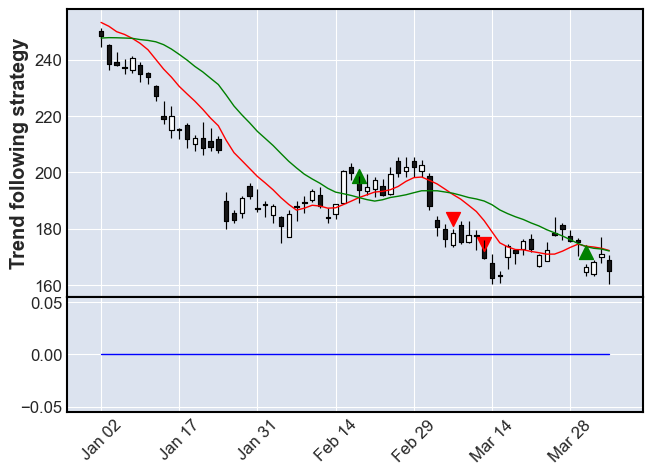

In [428]:
marker_offset = 5

apds = [
    mpf.make_addplot(df['buy_action'] + marker_offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='^', color = 'green', width=1),
    mpf.make_addplot(df['sell_action'] + marker_offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='v', color = 'red', width=1),
    mpf.make_addplot(df['sma-short'], panel=0, color='r', secondary_y=False, ylabel='long', width=1),
    mpf.make_addplot(df['sma-long'], panel=0, color='g', secondary_y=False, ylabel='short', width=1),
    mpf.make_addplot(df['profit'], panel=1, color='b', secondary_y=False, width=1),
    #mpf.make_addplot(df['exprofit'], panel=2, color='b', secondary_y=False, width=1),
]

mpf.plot(df, type='candle', addplot=apds, volume=False, ylabel='Trend following strategy')

In [429]:
1177.219355 - 980.000000

#(160.270004 - 133.419998) * 7.345226 # no fees
#(160.270004 - 133.419998) * 7.345226 - 20 - 160.270004 * 7.345226 * 0.02 # with fees

197.21935499999995

In [430]:
#45.907661
75.876195 +1.028327 + 3.966373 + 116.348460

197.219355

In [431]:
#df['qnt']

dq = df['qnt'].diff().fillna(0)
dq1 = dq.apply(lambda x: max(0, x)) + dq.apply(lambda x: min(0, x)).shift(1).fillna(0)

#(df['dclose'] * df['qnt']).cumsum()

# 2023-01-19 05:00:00+00:00       0.000000
# 2023-01-20 05:00:00+00:00     980.000000
# 2023-01-23 05:00:00+00:00    1055.876195
# 2023-01-24 05:00:00+00:00    1056.904522
# 2023-01-25 05:00:00+00:00    1060.870895
# 2023-01-26 05:00:00+00:00    1177.219355
# 2023-01-27 05:00:00+00:00       0.000000

(df['dclose'] * df['qnt'].shift(1).fillna(0) - df['dfee']).cumsum()



#a = df['2023-01-20' <= df.index]
#b = a[a.index <= '2023-01-27']
#b['Close'] #.sum() * df.loc['2023-01-20', 'qnt']


# df['dasset_quantity'].apply(lambda x: min(0, x)).shift(1).fillna(0)

#df['dasset_quantity'].apply(lambda x: max(0, x)) + df['dasset_quantity'].apply(lambda x: min(0, x)).shift(1).fillna(0)

Date
2024-01-02 05:00:00+00:00    0.0
2024-01-03 05:00:00+00:00    0.0
2024-01-04 05:00:00+00:00    0.0
2024-01-05 05:00:00+00:00    0.0
2024-01-08 05:00:00+00:00    0.0
                            ... 
2024-04-01 04:00:00+00:00    0.0
2024-04-02 04:00:00+00:00    0.0
2024-04-03 04:00:00+00:00    0.0
2024-04-04 04:00:00+00:00    0.0
2024-04-05 04:00:00+00:00    0.0
Length: 66, dtype: float64

In [441]:
#df[df['buy_action'] != 0][0].index
#df.loc[(df['buy_action'] != None).index, 'buy_action']

#first_buy_date = df.loc[df['buy_action'].notnull(), 'buy_action'].index[0]
#df.loc[ df.index < first_buy_date, 'sell_action'] = None
#df['sell_action']

df.loc[df['dsignal'] > 0, 'dsignal'].index[0]



Date
2024-01-02 05:00:00+00:00    0.0
2024-01-03 05:00:00+00:00    0.0
2024-01-04 05:00:00+00:00    0.0
2024-01-05 05:00:00+00:00    0.0
2024-01-08 05:00:00+00:00   -2.0
                            ... 
2024-04-01 04:00:00+00:00    0.0
2024-04-02 04:00:00+00:00    2.0
2024-04-03 04:00:00+00:00    0.0
2024-04-04 04:00:00+00:00    0.0
2024-04-05 04:00:00+00:00   -2.0
Name: dsignal, Length: 66, dtype: float64